In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import os

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


warnings.filterwarnings("ignore")



# <u>Tentative de modelisation et prédiction de la variable : Intensité d'utilisation energetique</u>

## <u>1 : Modelisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Regressions lineaires</u>

## <u>2 : Etude de l'importance de la note Energy Star</u>
### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>


## <u>1 : Modelisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Regressions lineaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
    -  Note : Donnees inutilisables, oublie d'export de la variable cible
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [2]:
general_file = "./data/seattle_predict_ghg_eui.csv"  # Used as backup


In [3]:
df_eui = pd.read_csv(general_file)
df_eui.set_index("OSEBuildingID", inplace=True)


In [4]:
df_eui.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_ptype_Mixed Use Property,ohe_ptype_Office,ohe_ptype_Other,ohe_ptype_Refrigerated Warehouse,ohe_ptype_Residence Hall,ohe_ptype_Small & Medium medical facility,ohe_ptype_Small & Mid-Sized Office,ohe_ptype_Supermarket & Grocery store,ohe_ptype_Warehouse,ohe_ptype_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,1927,1,12,60.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,1996,1,11,61.0,0.855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,1926,1,10,56.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,1926,1,11,27.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,1928,1,9,48.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_eui.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_nbhood_BALLARD',
       'ohe_nbhood_CENTRAL', 'ohe_nbhood_DELRIDGE', 'ohe_nbhood_DOWNTOWN',
       'ohe_nbhood_EAST', 'ohe_nbhood_GREATER DUWAMISH',
       'ohe_nbhood_LAKE UNION', 'ohe_nbhood_MAGNOLIA / QUEEN ANNE',
       'ohe_nbhood_NORTH', 'ohe_nbhood_NORTHEAST', 'ohe_nbhood_NORTHWEST',
       'ohe_nbhood_SOUTHEAST', 'ohe_nbhood_SOUTHWEST', 'ohe_ptype_Hospital',
       'ohe_ptype_Hotel', 'ohe_ptype_K-12 School', 'ohe_ptype_Large Office',
       'ohe_ptype_Mixed Use Property', 'ohe_ptype_Office', 'ohe_ptype_Other',
       'ohe_ptype_Refrigerated Warehouse', 'ohe_ptype_Residence Hall',
    

In [6]:
# Target : target_SourceEUI(kWh/m2) :

droplist = [
    "target_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "scaled_SourceEUI(kWh/m2)",  # not to scale
    ]

df_model = df_eui.drop(columns=droplist)


In [7]:
eui_target = "target_SourceEUI(kWh/m2)"
eui_regression = Linear_reg(dataframe=df_model, target=eui_target)


#### Execution : 
Parametres similaires à l'emission de GES, on ajustera au besoin: 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 10, 0.02

In [8]:
eui_regression.execute_all()


In [9]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.20000000000000004
Time used during fit = 8.741426916792989
Time used during predict = 0.00016479194164276123


Ridge: 

Ridge best Alpha : 3.7000000000000015
Time used during fit = 0.16645695827901363
Time used during predict = 8.224975317716599e-05


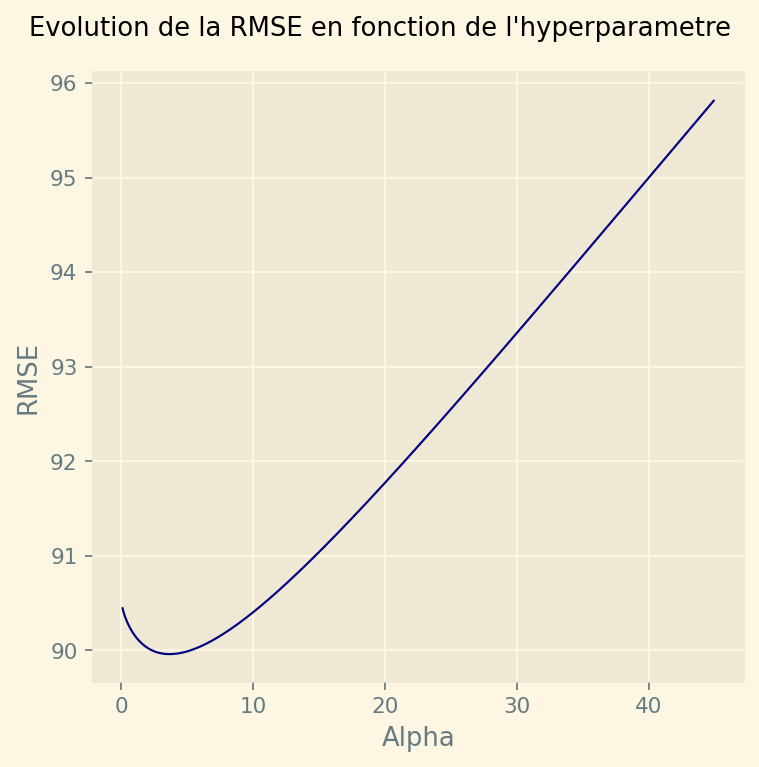

In [10]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.5700000000000001
Time used during fit = 0.3304571248590946
Time used during predict = 0.0010768333449959755


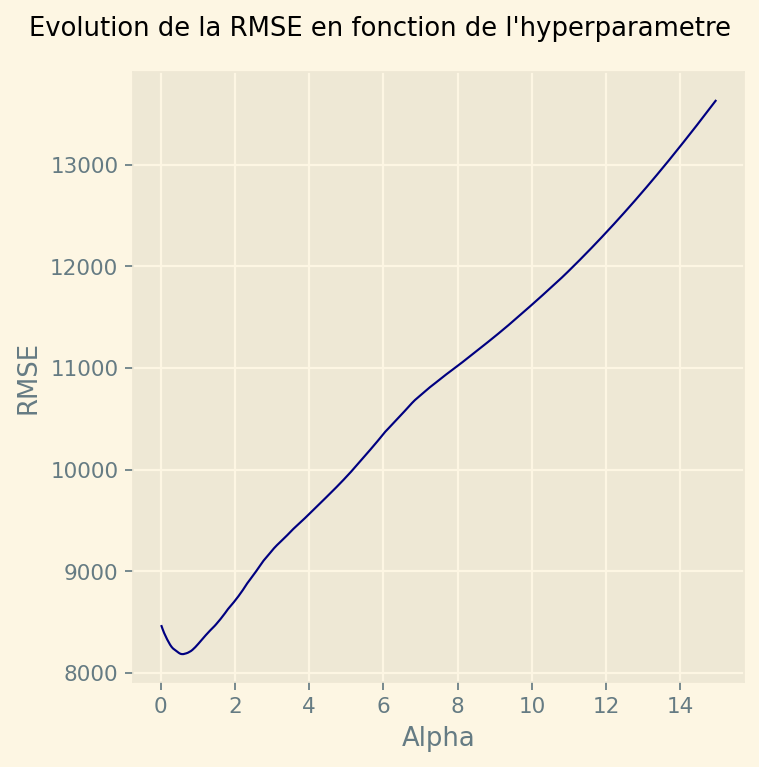

In [11]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [12]:
eui_regression.format_all_metrics()

,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,92.101628,0.782765,89.961810,0.816130,90.478164,0.812695,146.490210,0.813268
Test,116.972692,0.701641,116.964828,0.701681,114.844933,0.712397,115.962717,0.706771
